## ENSE 496 AD and AC project - Customer Recommendation System with using User based Collaborative Filtering Algorithm

In this project:

In [22]:
#Import 
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import random


Using the user-based mode 

In [23]:
# Function that calculate simlary by Cosine Similarity between two users
def simlaryCosDist(user1, user2):
    xSum = 0
    ySum = 0
    xySum = 0
    for rate1 in user1:
        for rate2 in user2:
            if rate1[0] == rate2[0]:
                xySum += rate1[1] * rate2[1]
                ySum += rate2[1] ** 2
                xSum += rate1[1] ** 2
    if xySum == 0: return 0
    return xySum / ((ySum * xSum) ** 0.5)


In [24]:
# generate user dictory
def genUserDic(datas):
    userRating = {}
    itemUser = {}
    for row in datas:
        rating = (row[1],row[2])
        if row[0] in userRating: userRating[row[0]].append(rating)
        else: userRating[row[0]] = [rating]

        if row[1] in itemUser: itemUser[row[1]].append(row[0])
        else: itemUser[row[1]] = [row[0]]

    return userRating, itemUser

In [25]:
# Get the near neighbors 
def getNearNeighbors(userId, userDic, itemDic):
    neighborsList = []
    #print(userDic)
    #print(userId)
    #print(userDic[userId])
    
    for ratings in userDic[userId]:
        for neighbor in itemDic[ratings[0]]:
            if neighbor != userId and neighbor not in neighborsList:
                neighborsList.append(neighbor)
    
    neighborsSimilary = []
    for neighbor in neighborsList:
        similary = simlaryCosDist(userDic[userId], userDic[neighbor])
        neighborsSimilary.append([similary, neighbor])
    neighborsSimilary.sort(reverse = True)
    return neighborsSimilary
    


In [26]:
def recommendation(userId,userDic, itemDic, k = 5):
    #print(itemDic[userId])
    neighbors = getNearNeighbors(userId, userDic, itemDic)[:k]
    #print("Neighbors",neighbors)
    recommendDic = {}
    for neighbor in neighbors:     #neighbor: [similary, neighbor Id]
        neighborUserId = neighbor[1]
        itemRating = userDic[neighborUserId] #[product Id , rating]
        for rating in itemRating:
            if rating[0] in recommendDic: recommendDic[rating[0]] += neighbor[0]
            else: recommendDic[rating[0]] = neighbor[0]

    recommendList = []
    for ele in recommendDic:  #ele: {product Id: sum of similary}
        recommendList.append([recommendDic[ele], ele])

    recommendList.sort(reverse=True)

    return [i[1] for i in recommendList], neighbors


In [28]:
def getPrecision(userId, recommendList,userDic):
    user = [i[0] for i in userDic[userId]]
    recommand = [i for i in recommendList]
    count = 0.0
    if len(user) >= len(recommand):
        for item in recommand:
            if item in user: count += 1
        precision = count / len(recommand)
    else:
        for item in user:
            if item in recommand: count += 1
        precision = count / len(user)
    return precision



In [29]:
def recall(testUsers, testUserDic, itemDic, userDic, recomMethod = recommendation, k = 10):
    """计算召回率"""
    hit = 0
    all_ = 0
    for userId in testUsers:
        recomList, neighbors = recomMethod(userId, userDic, itemDic,k=k)
        # print("recomList", recomList)
        # print("testUserDic[userId]", testUserDic[userId])
        for tureItem, mark in testUserDic[userId]:
            if tureItem in recomList:
                hit += 1
        all_ += len(testUserDic[userId])
    return hit / (all_ * 1.)

def precision(testUsers, testUserDic, itemDic, userDic, recomMethod = recommendation,k=10):
    """计算准确率"""
    hit = 0
    all_ = 0
    
    for userId in testUsers:
        recomList, neighbors = recomMethod(userId, userDic, itemDic,k=k)
        
        for reItem, mark in testUserDic[userId]:
            if reItem in recomList:
                hit += 1
        all_ += len(recomList)
    return hit / (all_ * 1.)

def f1(testUsers, testUserDic, itemDic, userDic, recomMethod = recommendation,k=10):
    recall_value = recall(testUsers, testUserDic, itemDic, userDic, recomMethod,k=k)
    precision_value = precision(testUsers, testUserDic, itemDic, userDic, recomMethod,k=k)
    return 2 * recall_value * precision_value / (precision_value + recall_value)

In [30]:
def data_split(dataset, x=0.8):
    '''
    切分数据集
    :param x: 训练集的比例，如x=0.8，则0.2是测试集
    :return: 用户-物品评分矩阵
    '''
    print("Spliting data...")

    trainset = dataset.sample(frac=x)
    trainset_index = trainset.index.tolist()
    testset = dataset.drop(trainset_index)
    #print(trainset.size, "\n", testset.size)
  
    # drop_list = []
    # for data in np.array(testset):
    #     if data[0] not in trainset["UserId"]:
    #         not_predi = testset[testset["UserId"] == data[0]].index
    #         drop_list.append(not_predi[0])
    # testset = testset.drop(drop_list)
    print("Data Splited!!!")

    return trainset, testset

In [31]:
dataset = dataset = pd.read_csv("ratings_Beauty.csv")
trainset, testset = data_split(dataset, x=0.8)
# trainset, testset = data_split(dataset[:100000], x=0.8)

Spliting data...
Data Splited!!!


In [32]:
trainUserDic, trainItemDic = genUserDic(np.array(trainset))

In [33]:
testUserDic, testItemDic = genUserDic(np.array(testset))

In [42]:
listTestUsers = list(testUserDic.keys())
print(len(listTestUsers))
users =[]
for userId in listTestUsers:
    if userId in trainUserDic.keys():
        users.append(userId)
lista = users[:50]
len(lista)

331141


50

In [43]:
recall_list = []
precision_list =[]
f1_list =[]
kv = []
for num in range(1,10):
    print(num)
    kv.append(num)
    recall_value = recall(lista,trainUserDic, trainItemDic, trainUserDic,k=num)
    recall_list.append(recall_value)

    precision_value = precision(lista,trainUserDic, trainItemDic, trainUserDic, k=num)
    precision_list.append(precision_value)

    f1_value = f1(lista,trainUserDic, trainItemDic, trainUserDic, k=num)
    f1_list.append(f1_value)

1
2
3
4
5
6
7
8
9


Plot the result

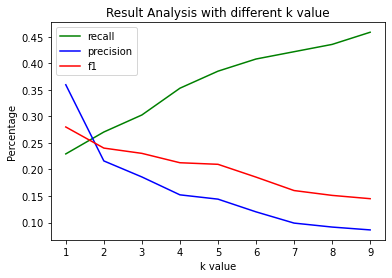

In [44]:
plt.title('Result Analysis with different k value')

plt.plot(kv, recall_list, color='green', label='recall')
plt.plot(kv, precision_list, color='blue', label='precision')
plt.plot(kv, f1_list,  color='red', label='f1')

plt.legend()
plt.xlabel('k value')
plt.ylabel('Percentage')
plt.show()

From the above figure, we know when k value is 2, geting best reults

Then, we come to see the how many test user will get the best reults with k value 2.

In [45]:
recall_list = []
precision_list =[]
f1_list =[]
kv = []
for num in range(1,20):
    userNum = num * 10
    print(userNum)
    kv.append(userNum)
    lista = users[:userNum]

    recall_value = recall(lista,trainUserDic, trainItemDic, trainUserDic,k=2)
    recall_list.append(recall_value)

    precision_value = precision(lista,trainUserDic, trainItemDic, trainUserDic, k=2)
    precision_list.append(precision_value)

    f1_value = f1(lista,trainUserDic, trainItemDic, trainUserDic, k=2)
    f1_list.append(f1_value)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


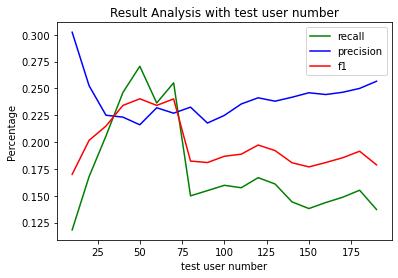

In [46]:
plt.title('Result Analysis with test user number')

plt.plot(kv, recall_list, color='green', label='recall')
plt.plot(kv, precision_list, color='blue', label='precision')
plt.plot(kv, f1_list,  color='red', label='f1')

plt.legend()
plt.xlabel('test user number')
plt.ylabel('Percentage')
plt.show()